In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('features.csv', on_bad_lines='skip')
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nLabel distribution:")
print(df['label'].value_counts())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222104 entries, 0 to 222103
Data columns (total 49 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   client_id                222104 non-null  object 
 1   path                     222104 non-null  object 
 2   sentence                 222104 non-null  object 
 3   up_votes                 222104 non-null  int64  
 4   down_votes               222104 non-null  int64  
 5   age                      222104 non-null  object 
 6   gender                   222104 non-null  object 
 7   accent                   163422 non-null  object 
 8   label                    222104 non-null  int64  
 9   energy                   172158 non-null  float64
 10  entropy_of_energy        172158 non-null  float64
 11  tempo                    172158 non-null  float64
 12  rms_mean                 172158 non-null  float64
 13  rms_std                  172158 non-null  float64
 14  rms_

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,label,energy,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687170.mp3,He associated with the Formists.,2,1,fifties,female,us,3,0.001645,...,22.049347,17.756376,36.478886,7.216048,6.322589,2.029570,-2.271826,-0.899689,-3.445649,-4.229555
1,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687171.mp3,"The ""ultra accelerator"" injection gives Derric...",2,1,fifties,female,us,3,0.006090,...,34.444332,9.215692,-13.941004,4.038210,-9.090697,-12.068948,-3.776986,-3.775194,-0.427106,0.274453
2,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687172.mp3,"Despite running as a joke, candidates have won...",2,0,fifties,female,us,3,0.007691,...,6.307040,12.119217,-14.692726,0.590535,-5.350560,-13.934402,-2.036303,-7.696416,-9.105513,-1.700456
3,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687173.mp3,Stoner also guest-starred in the television dr...,2,0,fifties,female,us,3,0.010188,...,34.362572,12.479874,35.520008,14.594222,13.626840,-3.039428,-6.813199,-2.690670,-2.222628,-3.604904
4,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687174.mp3,Rainelle was named for the Raine family.,2,0,fifties,female,us,3,0.006867,...,26.035561,21.564060,26.624199,10.622624,7.874703,2.720687,-8.067606,2.597533,0.322957,-10.668774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222099,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_19246427.mp3,We had dancers in the old days.,2,0,twenties,male,NaN,0,0.002220,...,14.600637,-0.518237,2.797074,-10.886346,0.275344,-1.149006,-6.698080,-4.911278,-6.481758,0.001764
222100,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_19261735.mp3,The taxonomic arrangement presented below is b...,2,0,twenties,male,NaN,0,0.002906,...,13.416354,15.975633,11.616440,-9.070229,4.966941,0.553191,-6.471150,2.454182,-4.776167,-3.428197
222101,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_19267150.mp3,Both of the converted ships saw action.,2,0,twenties,male,NaN,0,0.004863,...,5.603609,3.918690,3.999201,-8.417794,3.788709,0.563152,-5.002996,2.073364,-0.745641,-1.306939
222102,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_19267152.mp3,The Robert Hooke Science Centre is further awa...,2,1,twenties,male,NaN,0,0.009213,...,8.343183,-2.639572,4.442166,-13.847738,2.917359,-8.589788,-12.978580,-1.195083,-5.442918,-4.915794


In [3]:
df_clean = df.dropna(subset=['energy'], how='all')

print(f"Original shape: {df.shape}, Cleaned shape: {df_clean.shape}")

Original shape: (222104, 49), Cleaned shape: (172158, 49)


In [4]:
# Calculate signal-to-noise ratio (approximation)
df_clean['snr'] = df_clean['rms_mean'] / (df_clean['rms_std'] + 1e-10)

# Create a "vocal range" feature
df_clean['vocal_range'] = df_clean['pitch_max'] - df_clean['pitch_min']

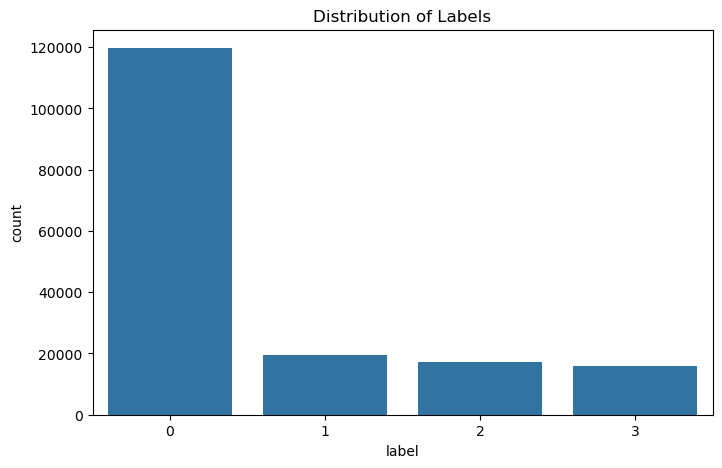

In [5]:
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df_clean)
plt.title('Distribution of Labels')
plt.show()

In [6]:
# label_0_indices = df_clean[df_clean['label'] == 0].index[:100000]
# df_clean = df_clean.drop(label_0_indices)

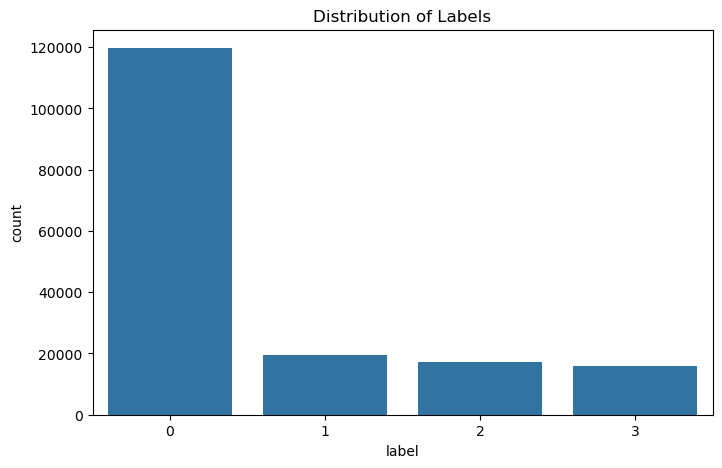

In [7]:
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df_clean)
plt.title('Distribution of Labels')
plt.show()

In [8]:
import pandas as pd
from sklearn.utils import resample

# Separate each class
df_majority_1 = df_clean[df_clean.label == 0]
df_class_1  = df_clean[df_clean.label == 1]
df_class_2  = df_clean[df_clean.label == 2]
df_class_3  = df_clean[df_clean.label == 3]

df_majority_2 = df_clean[df_clean.gender == "male"]
df_class_4  = df_clean[df_clean.gender == 'male']
df_class_5  = df_clean[df_clean.gender == 'female']

df_majority_3 = df_clean[df_clean.age == "twenties"]
df_class_6  = df_clean[df_clean.age == 'twenties']
df_class_7  = df_clean[df_clean.age == 'fifties']


# Get the size of the majority class
n_samples_1 = len(df_majority_1)
n_samples_2 = len(df_majority_2)
n_samples_3 = len(df_majority_3)

# Upsample each minority class
df_class_1_upsampled = resample(df_class_1, replace=True, n_samples=n_samples_1, random_state=42)
df_class_2_upsampled = resample(df_class_2, replace=True, n_samples=n_samples_1, random_state=42)
df_class_3_upsampled = resample(df_class_3, replace=True, n_samples=n_samples_1, random_state=42)
df_class_5_upsampled = resample(df_class_5, replace=True, n_samples=n_samples_2, random_state=42)
df_class_7_upsampled = resample(df_class_7, replace=True, n_samples=n_samples_3, random_state=42)


# Combine back all classes
df_upsampled = pd.concat([df_majority_1, df_class_1_upsampled, df_class_2_upsampled, df_class_3_upsampled])
df_upsampled = pd.concat([df_majority_2, df_class_5_upsampled])
df_upsampled = pd.concat([df_majority_3, df_class_7_upsampled])

# Shuffle the dataset
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)
df_clean = df_upsampled


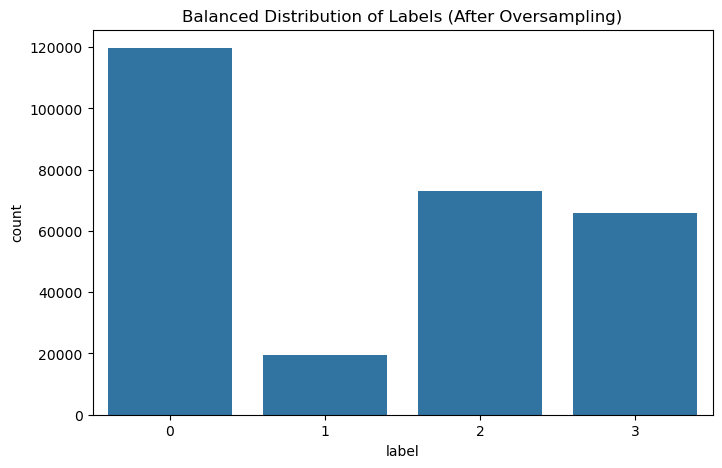

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df_clean)
plt.title('Balanced Distribution of Labels (After Oversampling)')
plt.show()


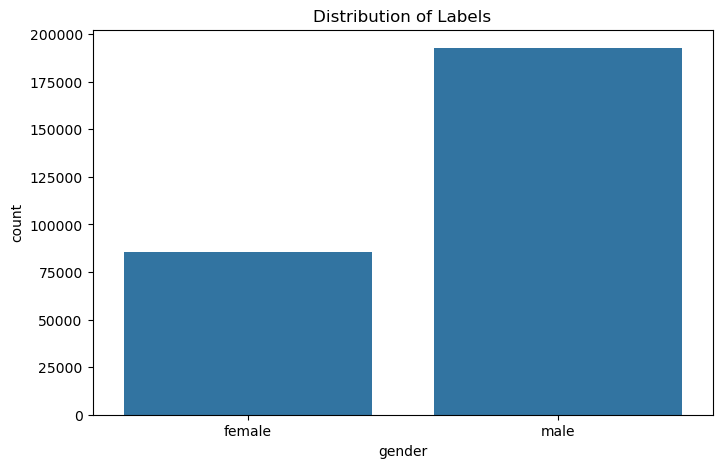

In [10]:
plt.figure(figsize=(8,5))
sns.countplot(x='gender', data=df_clean)
plt.title('Distribution of Labels')
plt.show()

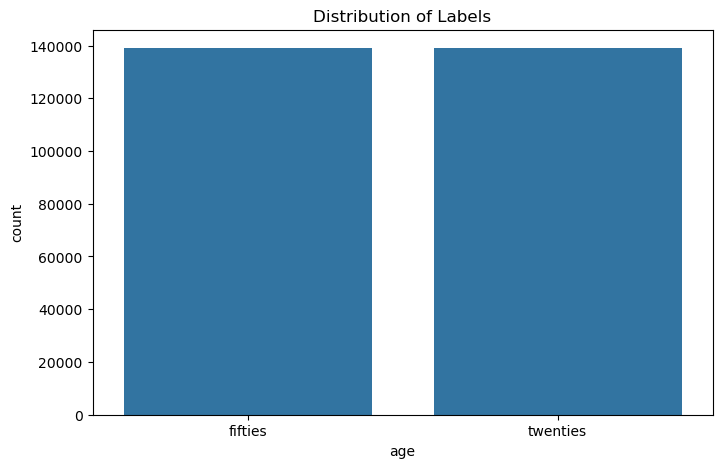

In [11]:
plt.figure(figsize=(8,5))
sns.countplot(x='age', data=df_clean)
plt.title('Distribution of Labels')
plt.show()

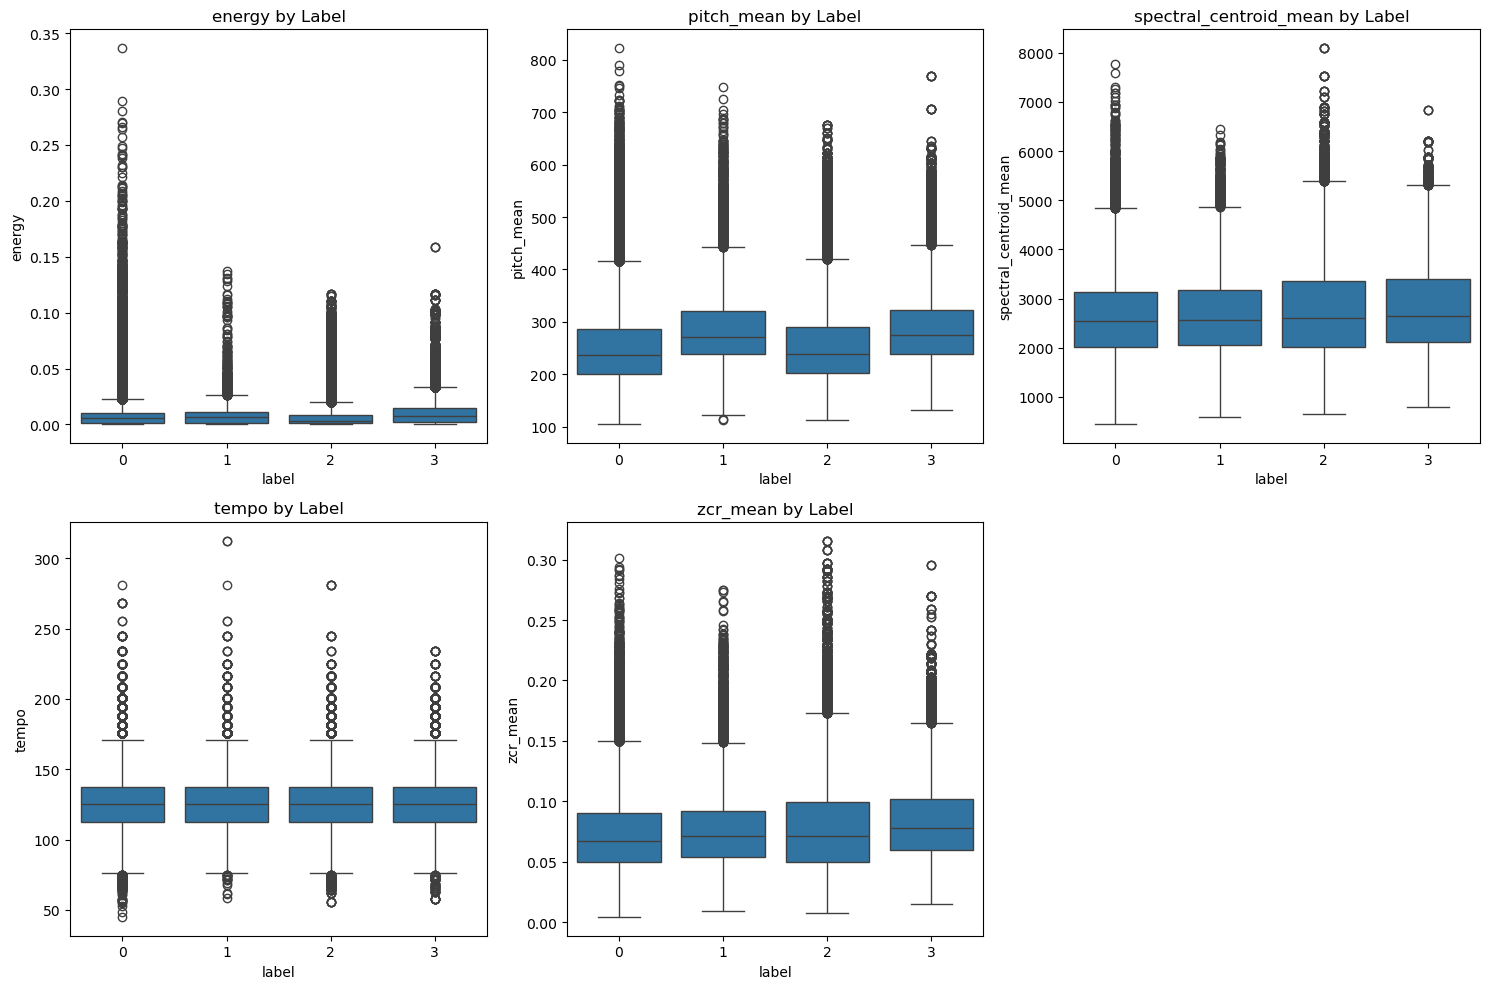

In [12]:
features_to_plot = ['energy', 'pitch_mean', 'spectral_centroid_mean', 'tempo', 'zcr_mean']

plt.figure(figsize=(15,10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='label', y=feature, data=df_clean)
    plt.title(f'{feature} by Label')
plt.tight_layout()
plt.show()

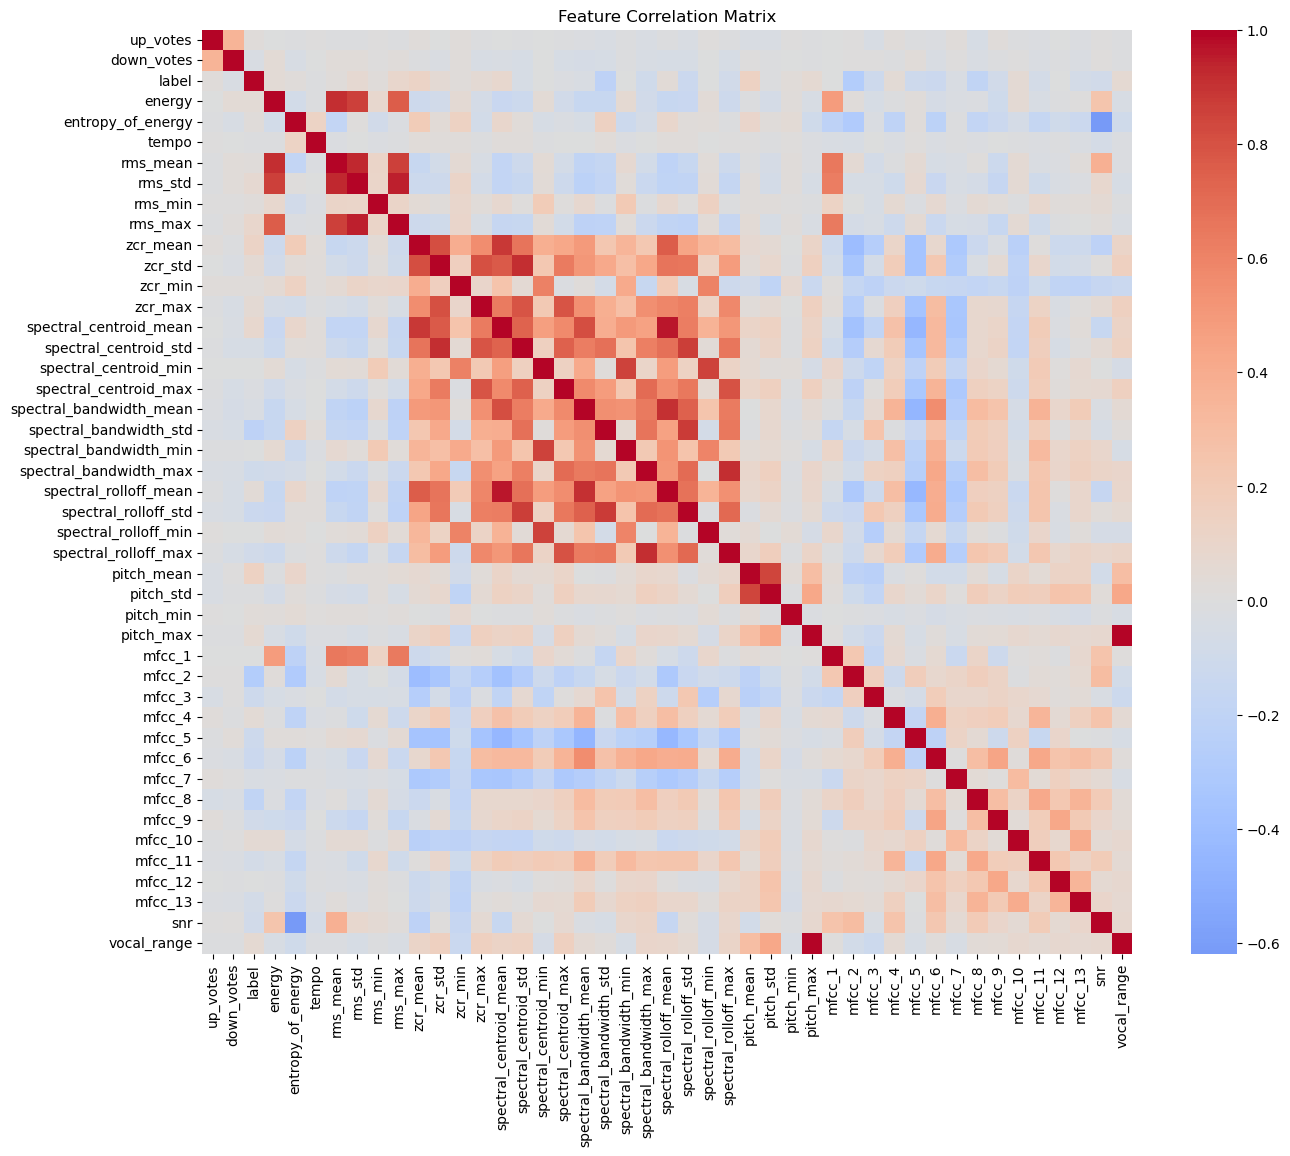

In [13]:
# Calculate correlation matrix
corr_matrix = df_clean.select_dtypes(include=[np.number]).corr()

# Plot heatmap
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [14]:
selected_features = [
    'pitch_mean',
    'pitch_std',
    'spectral_centroid_mean',
    'spectral_bandwidth_mean',
    'spectral_rolloff_mean',
    'energy',
    'mfcc_1','mfcc_2','mfcc_3','mfcc_4','mfcc_5','mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10','mfcc_11','mfcc_12','mfcc_13'
]

demographic_features = ['age', 'gender']

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate features and target
X = df_clean[selected_features + demographic_features]
y = df_clean['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Preprocessing pipeline
numeric_features = selected_features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = demographic_features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
X.head()


X_train shape: (194657, 21), y_train shape: (194657,)
X_test shape: (83425, 21), y_test shape: (83425,)


,pitch_mean,pitch_std,spectral_centroid_mean,spectral_bandwidth_mean,spectral_rolloff_mean,energy,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,age,gender
0,313.090877,213.973548,2657.057947,1806.044418,4565.719561,0.001248,-348.481018,131.131195,1.360921,20.668501,...,-14.647307,-22.182287,-17.853634,-7.573953,-1.040927,-8.532400,-7.983645,-8.635787,fifties,female
1,216.065379,156.514871,3771.564840,2984.430684,6638.901013,0.001552,-415.534271,101.125801,-27.091944,24.543583,...,5.752772,-19.650068,-10.627404,-0.059335,-18.349789,-5.634731,-5.748588,-2.655690,fifties,female
2,218.194249,220.234604,3538.968385,3257.926191,6760.674055,0.010796,-422.571625,107.124451,20.387774,26.990356,...,7.811064,1.516254,3.761860,-2.553594,-5.417889,7.099375,-4.430019,-6.875200,twenties,male
3,437.407194,384.945529,2699.728251,3632.971826,6362.693050,0.001550,-499.649261,81.212700,5.608990,35.084991,...,21.140589,5.531438,11.156766,7.286912,5.981217,7.289612,3.819008,7.602324,fifties,male
4,370.863063,351.504857,1927.079491,1712.729595,3435.639004,0.000231,-691.853943,85.163261,8.550106,-1.087499,...,-0.185191,4.224649,8.654717,0.423002,-7.134037,-9.150444,-6.348443,-2.382102,fifties,male


In [16]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data (using only audio features)
gender_features = X_train.drop(['age', 'gender'], axis=1)
gender_target = X_train['gender']

# Train/test split
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(
    gender_features, gender_target, test_size=0.3, random_state=42)

# Train model
gender_model = RandomForestClassifier()
gender_model.fit(X_train_gender, y_train_gender)

# Evaluate
print("Gender Accuracy:", gender_model.score(X_test_gender, y_test_gender))

Gender Accuracy: 0.9459570533237439


In [17]:
age_features = X_train.drop(['age', 'gender'], axis=1)
age_target = X_train['age']

X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    age_features, age_target, test_size=0.3, random_state=42)

age_model = RandomForestClassifier()
age_model.fit(X_train_age, y_train_age)

print("Age Accuracy:", age_model.score(X_test_age, y_test_age))

Age Accuracy: 0.9576526593376485


In [18]:
# label_features

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load your dataset (replace with your actual data loading)
# df_clean = pd.read_csv("your_data.csv")

# Define features (modify as needed)
# selected_features = ['feature1', 'feature2', ...]  # Your audio features
# demographic_features = ['age', 'gender']          # Demographic features

# Separate features and target
X = df_clean[selected_features + demographic_features]
y = df_clean['label']

# Split data (stratify by label)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# ==============================================
# STEP 1: Train Demographic Predictors (Gender/Age)
# ==============================================

# Gender prediction model (using only audio features)
X_train_gender = X_train[selected_features]
y_train_gender = X_train['gender']

gender_model = RandomForestClassifier(random_state=42)
gender_model.fit(X_train_gender, y_train_gender)

# Age prediction model (using only audio features)
X_train_age = X_train[selected_features]
y_train_age = X_train['age']

age_model = RandomForestClassifier(random_state=42)
age_model.fit(X_train_age, y_train_age)

# Evaluate demographic models
print("=== Gender Model Evaluation ===")
X_test_gender = X_test[selected_features]
print(classification_report(X_test['gender'], gender_model.predict(X_test_gender)))

print("\n=== Age Model Evaluation ===")
X_test_age = X_test[selected_features]
print(classification_report(X_test['age'], age_model.predict(X_test_age)))

# ==============================================
# STEP 2: Prepare Features for Final Model
# ==============================================

# Create encoders (fit only on training data)
gender_encoder = LabelEncoder().fit(X_train['gender'])
age_encoder = LabelEncoder().fit(X_train['age'])

# Generate predicted demographics for train/test sets
X_train_pred = X_train[selected_features].copy()
X_train_pred['pred_gender'] = gender_model.predict(X_train[selected_features])
X_train_pred['pred_age'] = age_model.predict(X_train[selected_features])

X_test_pred = X_test[selected_features].copy()
X_test_pred['pred_gender'] = gender_model.predict(X_test[selected_features])
X_test_pred['pred_age'] = age_model.predict(X_test[selected_features])

# Encode predicted demographics
X_train_pred['pred_gender'] = gender_encoder.transform(X_train_pred['pred_gender'])
X_train_pred['pred_age'] = age_encoder.transform(X_train_pred['pred_age'])
X_test_pred['pred_gender'] = gender_encoder.transform(X_test_pred['pred_gender'])
X_test_pred['pred_age'] = age_encoder.transform(X_test_pred['pred_age'])

# ==============================================
# STEP 3: Train Final Model
# ==============================================

# Preprocessing pipeline
numeric_features = selected_features
categorical_features = ['pred_gender', 'pred_age']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Final model pipeline
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train
final_model.fit(X_train_pred, y_train)

# Evaluate
print("\n=== Final Model Evaluation ===")
y_pred = final_model.predict(X_test_pred)
print(classification_report(y_test, y_pred))

# ==============================================
# STEP 4: Prediction Function
# ==============================================

def predict_label(audio_features):
    """Predict label from audio features using the full pipeline"""
    # Convert to DataFrame if needed
    if not isinstance(audio_features, pd.DataFrame):
        audio_features = pd.DataFrame([audio_features], columns=selected_features)

    # Predict demographics
    pred_gender = gender_model.predict(audio_features)[0]
    pred_age = age_model.predict(audio_features)[0]

    # Encode demographics
    pred_gender_encoded = gender_encoder.transform([pred_gender])[0]
    pred_age_encoded = age_encoder.transform([pred_age])[0]

    # Combine features
    features = audio_features.copy()
    features['pred_gender'] = pred_gender_encoded
    features['pred_age'] = pred_age_encoded

    # Make final prediction
    return final_model.predict(features)[0]

=== Gender Model Evaluation ===
              precision    recall  f1-score   support

      female       0.96      0.89      0.92     25598
        male       0.95      0.98      0.97     57827

    accuracy                           0.95     83425
   macro avg       0.96      0.94      0.94     83425
weighted avg       0.95      0.95      0.95     83425


=== Age Model Evaluation ===
              precision    recall  f1-score   support

     fifties       0.97      0.98      0.98     41713
    twenties       0.98      0.97      0.98     41712

    accuracy                           0.98     83425
   macro avg       0.98      0.98      0.98     83425
weighted avg       0.98      0.98      0.98     83425


=== Final Model Evaluation ===
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     35910
           1       0.78      0.51      0.62      5802
           2       0.97      0.98      0.97     21917
           3       0.97      0.98  